# Denoising Autoencoder
In this lab, you will be applying a noise filter to MNIST images and using a denoising autoencoder to reconstruct the original image.

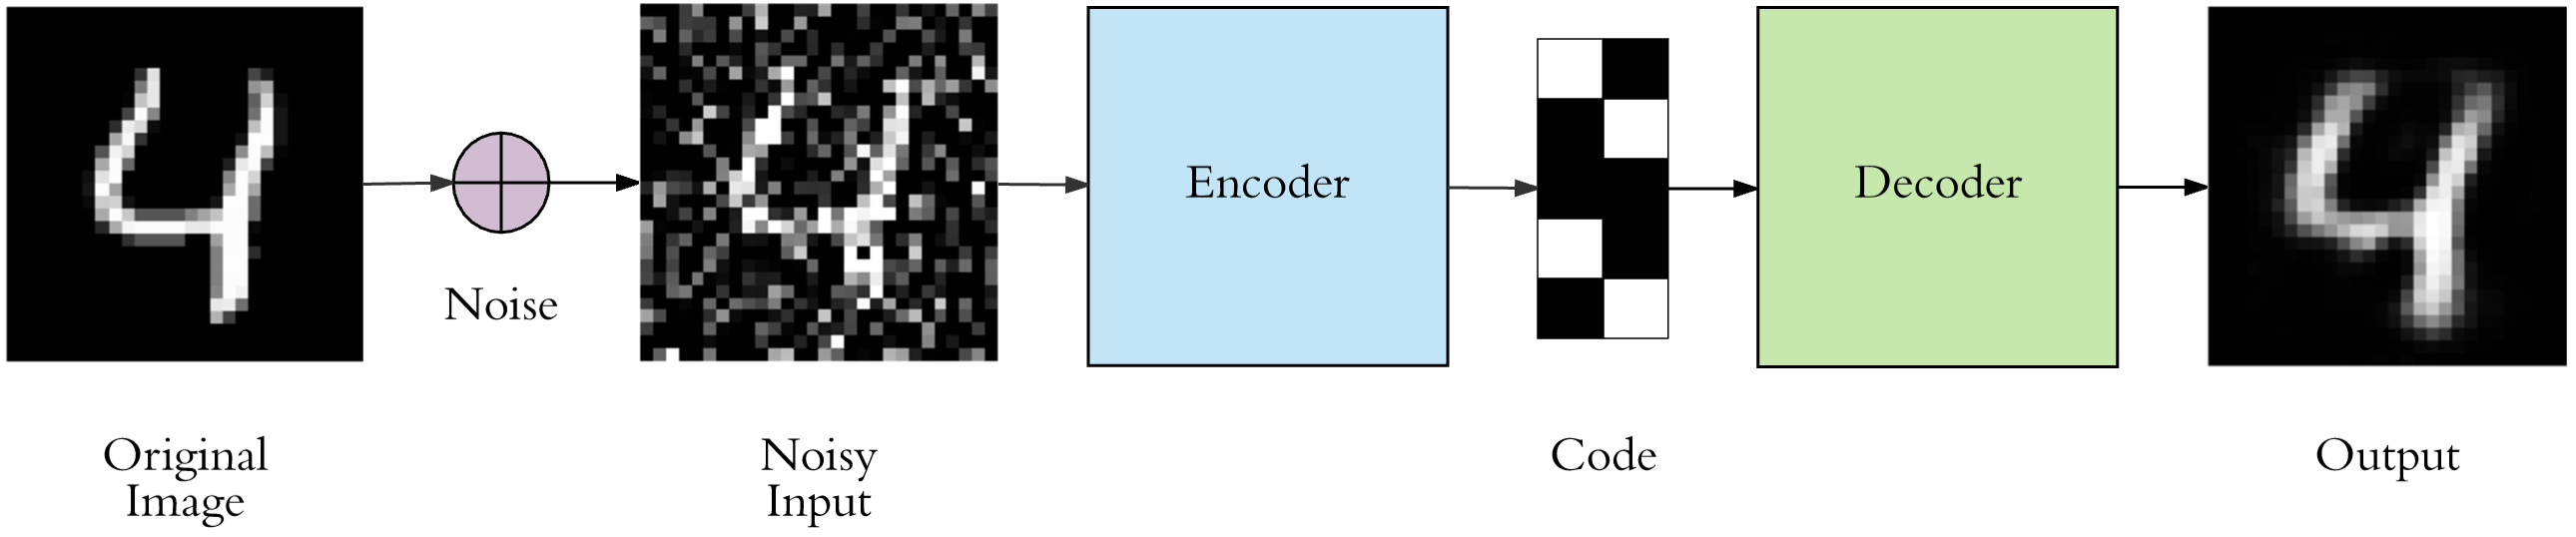

## Setting up AWS

1. Before we get started, each of you will need to make an AWS account so that you can train your model on something more powerful than your personal device.
    
    Step one is to create an AWS **Student** Account. Students get $100 of free credit: https://aws.amazon.com/education/awseducate/


2. Now we must request a server to run our code on. For the purposes of this homework, you can use a spot instance. Spot instances are on-demand servers that are cheaper to use than normal EC2 instances, but can be terminated at any time (so will lose data stored on that machine). 


    A p2.xlarge should suffice for this project. 


3. Then, push your code to a separate github repo and then `ssh` into your server, pull the repo. 

    Another option is to use `scp` to securely send the files from your local machine to the server: http://www.hypexr.org/linux_scp_help.php
    

4. Since jupyter runs in the browser, we need a way to interact with the notebook on our local machine, but have everything run remotely. 

    Follow these steps https://ljvmiranda921.github.io/notebook/2018/01/31/running-a-jupyter-notebook/ to get the jupyter notebook up and running so that you can start training your model.


## Lets Get Started!

In [1]:
import os
#Disable the warnings for now cuz they are annoying
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/nabeel/anaconda3/envs/nmep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nabeel/anaconda3/envs/nmep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nabeel/anaconda3/envs/nmep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nabeel/anaconda3/envs/nmep/lib/python3.6/s

We will be implementing the diagram below. To learn more, read the following: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/. The first few paragraphs should suffice to get a basic understanding of what an autoencoder is.

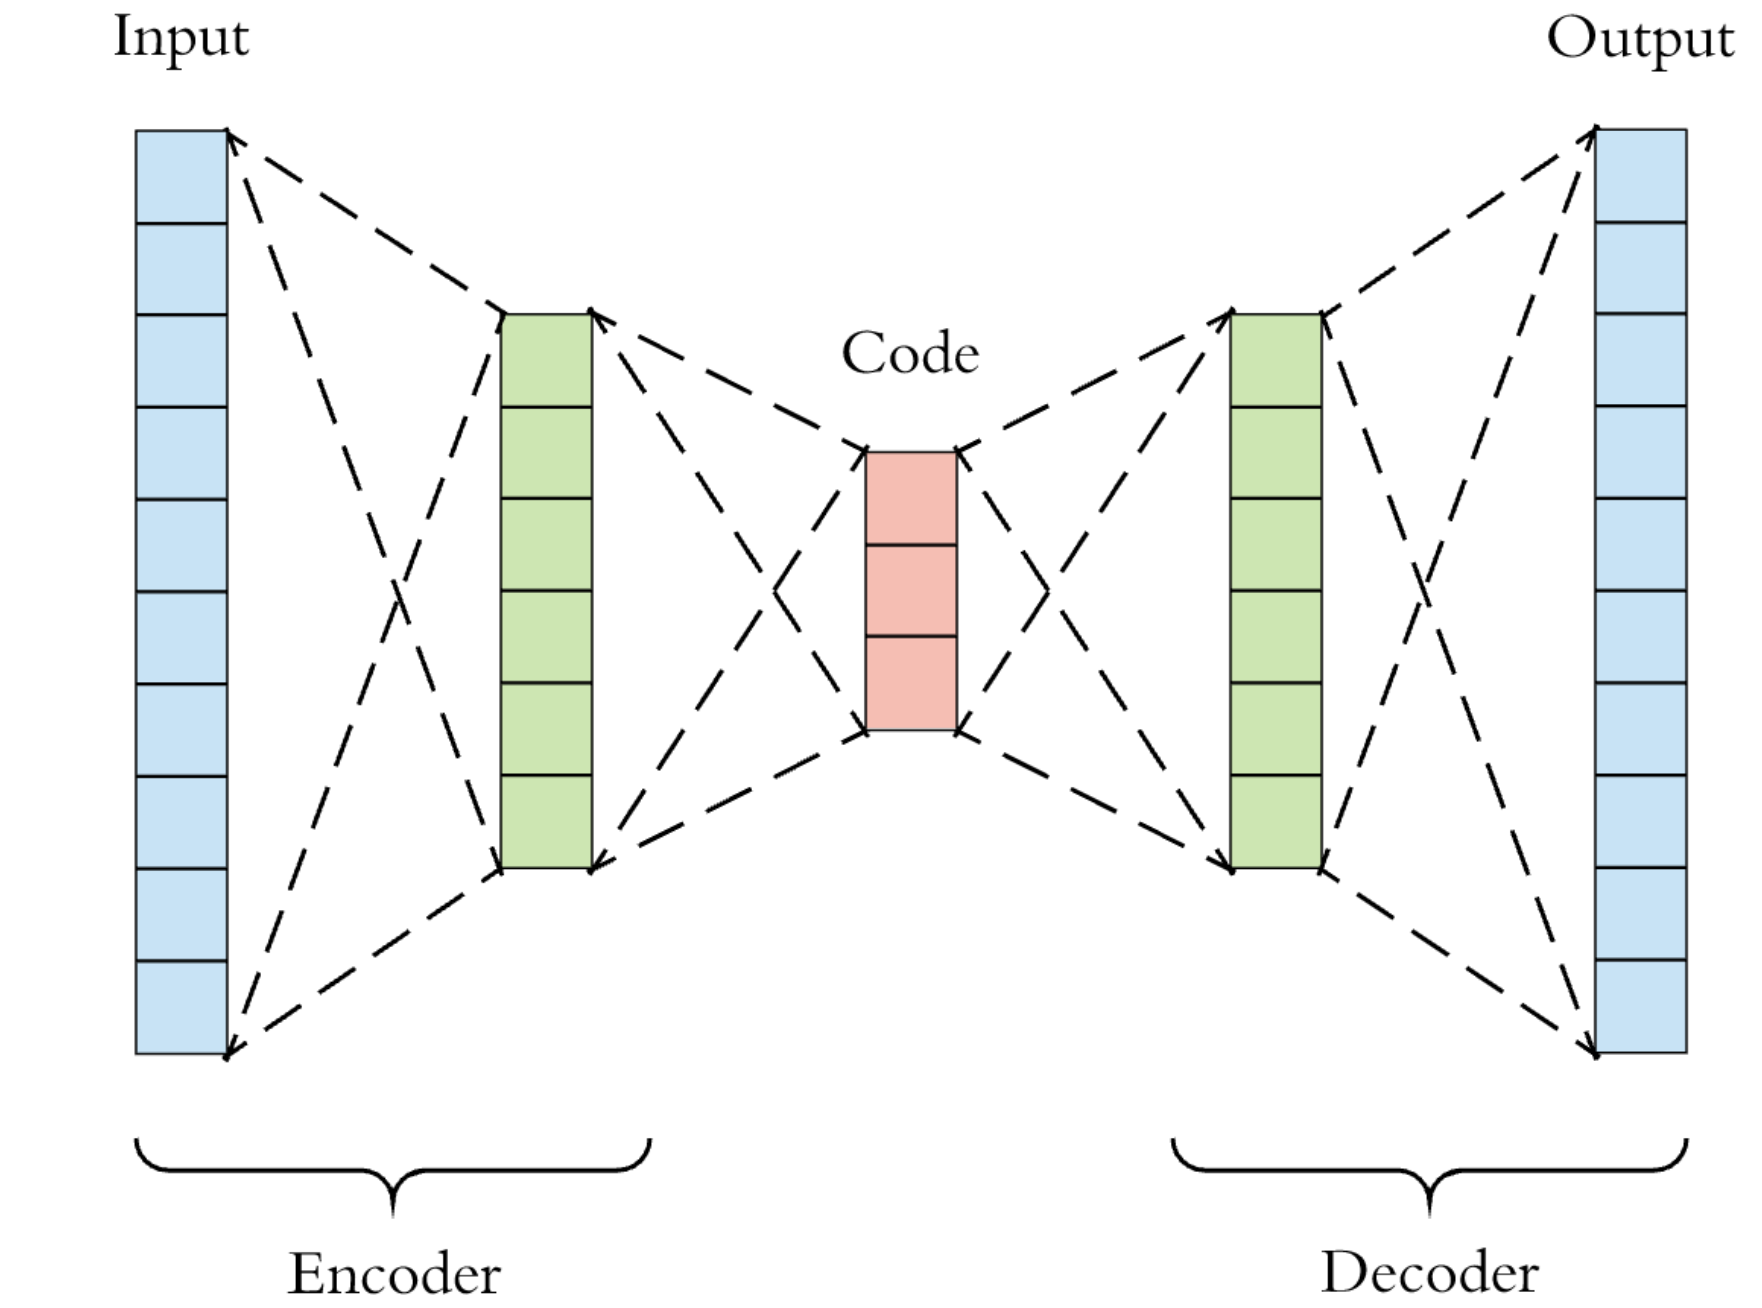

As seen in the first figure, a denoising autoencoder takes some noisy image and tries to reconstruct the original image. We will be attempting to reconstruct noisy MNIST images. To start, complete the below function to apply a mask to each input X. 

In [2]:
def masking_noise(X, v):
    """ Apply masking noise to data in X, in other words a fraction v of elements of X
    (chosen at random) is forced to zero.
    X is of size [batch_size, features]
    """
    
    X_noise = X.copy() #don't edit the original image

    n_samples = X.shape[0]
    n_features = X.shape[1]

    for i in range(n_samples):
        mask = np.random.choice(np.arange(n_features), int(v * n_features), replace= False)
        for m in mask:
            X_noise[i][m] = 0.
    return X_noise

### Network parameters and Hyperparameters

In [3]:
# Parameters
learning_rate = 0.01
training_epochs = 50
batch_size = 64

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28) NOTE: no 3rd dimension b/c B&W

Create a placeholder value for the input images after they are flattened to an array of dimension 784.

In [4]:
#TODO: Fill in the dots
X = tf.placeholder(shape=[None, 784], dtype=tf.float32, name="X")
X_noise = tf.placeholder(shape=[None, 784], dtype=tf.float32, name="X_noise")

We will be creating a dictionary that maps a name to each weight/bias variable. Fill in the weights and biases dictionary for all the layers. Initialize all weights by randomly sampling from a truncated normal distribution with a standard deviation of 0.1: see `tf.random.truncated_normal`.

In [5]:
#TODO: Fill in the dots
weights = {
    'encoder_w1': tf.get_variable("Weights1", initializer=tf.random.truncated_normal([n_input, n_hidden_1], stddev=0.1)),
    'encoder_w2': tf.get_variable("Weights2", initializer=tf.random.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
    'decoder_w1': tf.get_variable("Weights3", initializer=tf.random.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.1)),
    'decoder_w2': tf.get_variable("Weights4", initializer=tf.random.truncated_normal([n_hidden_1, n_input], stddev=0.1))
}

bias = {
    "encoder_b1": tf.get_variable("bias1", initializer=tf.random.truncated_normal([n_hidden_1], stddev=0.1)),
    "encoder_b2": tf.get_variable("bias2", initializer=tf.random.truncated_normal([n_hidden_2], stddev=0.1)),
    "decoder_b1": tf.get_variable("bias3", initializer=tf.random.truncated_normal([n_hidden_1], stddev=0.1)),
    "decoder_b2": tf.get_variable("bias4", initializer=tf.random.truncated_normal([n_input], stddev=0.1))
}

Instructions for updating:
Colocations handled automatically by placer.


Fill in the encoder and decoder functions:
* The encoder function takes in a noisy image and returns a 128 dimensional tensor (the middle layer)
* The decoder function takes in the middle layer of the network and outputs the restored image

In [6]:
def encoder(X):
    layer1 = tf.nn.tanh(tf.matmul(X, weights['encoder_w1']) + bias['encoder_b1'])
    layer2 = tf.matmul(layer1, weights['encoder_w2']) + bias['encoder_b2']
    return layer2
    
def decoder(x):
    layer1 = tf.nn.tanh(tf.matmul(x, weights['decoder_w1']) + bias['decoder_b1'])
    layer2 = tf.matmul(layer1, weights['decoder_w2']) + bias['decoder_b2']
    return layer2

*Side Note:* Tensorflow will automatically place your computation on a GPU if one is available. If you have multiple GPUs available and would like to distribute your training, please see the article below.
https://jhui.github.io/2017/03/07/TensorFlow-GPU/

In [7]:
#Print out the devices that are available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7486737715702189018]

Create the encoder and decoder layers using the functions above.

In [8]:
#TODO: Fill in the dots
# encoder_op = ...
# decoder_op = ...
encoder_op = encoder(X_noise)
decoder_op = decoder(encoder_op)

pred = decoder_op

Calculate the entropy by taking the **Log Loss** (look through tf documentation) and calculate the overall loss by taking the mean of the entropy. The predicted value of this network is the output of the decoder and the true value is the original MNIST image *before* the noise filter is added.

In [15]:
#TODO: Fill in the dots
entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=pred)
loss = tf.reduce_mean(entropy)

Define the optimizer as the RMSPropOptimizer which minimizes the loss calculated above.

In [17]:
#TODO: Fill in the dots
# optimizer = tf.keras.optimizers.RMSprop(learning_rate, epsilon=1e-07).minimize(loss)
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate, name='RMSProp').minimize(loss)
#optimizer.minimize(loss)

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
MNIST = input_data.read_data_sets("../data/mnist", one_hot = True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


Start a session and initialize all the variables created above.

In [19]:
#TODO: Start the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

For each training epoch, take a batch of the training examples, apply the noise filter to each image, and run the optimizer and loss. At the end of each epoch, print the loss and confirm it decreases with each epoch. You can plot the loss in tensorboard if you would like. 

In [20]:
#TODO: Implement Training Loop
num_batches = (int) (MNIST.train.num_examples/batch_size)
epochs = 5
for i in range(epochs):
    total_loss = 0
    for batch in range(num_batches):
        X_batch, y_batch = MNIST.train.next_batch(batch_size)
        X_batch = masking_noise(X_batch, 0.3)
        o, l = sess.run([optimizer, loss], feed_dict={X: X_batch, X_noise: X_batch})
        total_loss += l
    print("Epoch {0}: {1}".format(i, total_loss))

Epoch 0: 203.627380117774
Epoch 1: 132.84217877686024
Epoch 2: 129.9871720969677
Epoch 3: 129.08426561951637
Epoch 4: 128.70400680601597


Use the code below to plot the original image, the noisy image, and the reconstructed image. You can try tweaking the hyperparameters above to see if you can improve your accuracy!

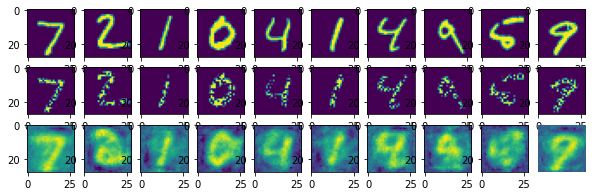

In [21]:
x = MNIST.test.images[:10]
x_noise = masking_noise(x, 0.5)
pred_img = sess.run(pred, feed_dict = {X: x, X_noise:x_noise})
f, a = plt.subplots(3, 10, figsize=(10, 3))
plt.axis('off')
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)))
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)))
    a[2][i].imshow(np.reshape(pred_img[i], (28, 28)))
plt.show()
        

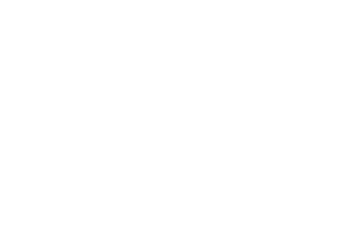

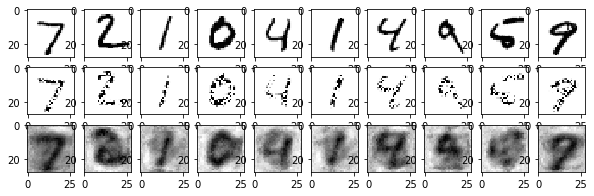

In [22]:
plt.axis('off')
f, a = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    a[0][i].imshow(np.reshape(x[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[1][i].imshow(np.reshape(x_noise[i], (28, 28)), cmap='Greys',  interpolation='nearest')
    a[2][i].imshow(np.reshape(pred_img[i], (28, 28)), cmap='Greys',  interpolation='nearest')
plt.show()